In [1]:
import os
import sys

print(os.getcwd())
cwd0 = './config/'
sys.path.append(cwd0)

import visualID_Eng as vID
from visualID_Eng import color
vID.init(cwd0)
import tools4PytChem as t4p

/home/romuald/ENSEIGNEMENT/0-JupyterNotebooks/PytChem


**Start at:** Wednesday 05 April 2023, 12:30:36  
**Hostname:** insa-12842 (Linux)

<p style="text-align: center"><img width="800px" src="./config/svg/PytChemBanner.svg" style="margin-left:auto; margin-right:auto"/></p>

# 2nd-order NMR. The AB system case

In [2]:
import scipy.constants as sc
import numpy as np
from matplotlib import pyplot as plt

import sympy as sym
from tools4PytChem import PrintLatexStyleSymPyEquation as ple

from sympy.physics.quantum.pauli import SigmaX, SigmaY, SigmaZ, SigmaPlus, SigmaMinus
from sympy.physics.paulialgebra import evaluate_pauli_product as epp
from sympy.physics.quantum import TensorProduct
from sympy.physics.quantum import represent

## **0.** Basic principles of NMR

### Gyromagnetic ratio

In [3]:
print(sc.find("gyromag"))
print(f'{color.BOLD}Proton gyromagnetic ratio: {sc.physical_constants["proton gyromag. ratio"]}{color.OFF}')
print(sc.find("Planck"))
print(f'{color.BOLD}Planck constant: {sc.physical_constants["Planck constant"]}{color.OFF}')
print(f'{color.BOLD}Reduced Planck constant: {sc.physical_constants["reduced Planck constant"]}{color.OFF}')

gamH = sc.value("proton gyromag. ratio")
h = sc.value("Planck constant")
hbar = sc.value("reduced Planck constant")

['electron gyromag. ratio', 'electron gyromag. ratio in MHz/T', 'neutron gyromag. ratio', 'neutron gyromag. ratio in MHz/T', 'proton gyromag. ratio', 'proton gyromag. ratio in MHz/T', 'shielded helion gyromag. ratio', 'shielded helion gyromag. ratio in MHz/T', 'shielded proton gyromag. ratio', 'shielded proton gyromag. ratio in MHz/T']
Proton gyromagnetic ratio: (267522187.44, 's^-1 T^-1', 0.11)
['Planck constant', 'Planck constant in eV/Hz', 'Planck length', 'Planck mass', 'Planck mass energy equivalent in GeV', 'Planck temperature', 'Planck time', 'molar Planck constant', 'reduced Planck constant', 'reduced Planck constant in eV s', 'reduced Planck constant times c in MeV fm']
Planck constant: (6.62607015e-34, 'J Hz^-1', 0.0)
Reduced Planck constant: (1.054571817e-34, 'J s', 0.0)


In [4]:
def nu0(B0):
    import scipy.constants as sc
    import numpy as np
    gamH = sc.value("proton gyromag. ratio")
    return gamH*B0/(2*np.pi)

B0 = 2.35
print(f"{color.BOLD}Absolute resonance frequency for the proton (ν0) = {nu0(B0):.2e} Hz = {nu0(B0)/1e6:.1f} MHz for B0 = {B0:.2f} T{color.OFF}")

Absolute resonance frequency for the proton (ν0) = 1.00e+08 Hz = 100.1 MHz for B0 = 2.35 T


###  Nuclear Zeeman splitting

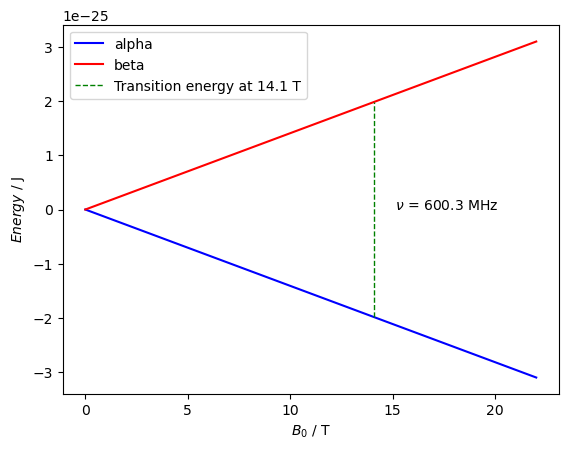

In [5]:
def EZeemanEffect(mI,B0):
    import scipy.constants as sc
    import numpy as np
    gamH = sc.value("proton gyromag. ratio")
    hbar = sc.value("reduced Planck constant")
    return -mI*gamH*hbar*B0

B0 = np.linspace(0,22,10)
HighB0 = 14.1
freq = 2*EZeemanEffect(-0.5,HighB0)/h
plt.plot(B0,EZeemanEffect(0.5,B0),'b',label='alpha')
plt.plot(B0,EZeemanEffect(-0.5,B0),'r',label='beta')
plt.vlines(HighB0,EZeemanEffect(0.5,HighB0),EZeemanEffect(-0.5,HighB0),linewidth=1,linestyles='--', color='g', label=f'Transition energy at {HighB0} T')
plt.xlabel("$B_0$ / T")
plt.ylabel("$Energy$ / J")
plt.annotate(f'$\\nu$ = {freq/1e6:.1f} MHz', xy=(HighB0, 0), xytext=(HighB0+1, 0))
plt.legend()



### Larmor frequency

$$\nu_{\mathrm{L}}(\mathrm{X})=\frac{\gamma_{\mathrm{H}}B_{0}}{2\pi}(1-\sigma_{\mathrm{X}})$$

In [6]:
def Larmor(B0,sigma):
    import scipy.constants as sc
    import numpy as np
    gamH = sc.value("proton gyromag. ratio")
    nu = gamH*B0*(1-sigma)/(2*np.pi)
    return nu

Calculation of $\nu_\mathrm{L}$ for two magnetic fields: $B_0$ = 2.35 T (100 MHz for H) & 14.1 T (600 MHz for H)

In [7]:
B0_100MHz = 2.35 #Tesla
nu0_100MHz = Larmor(B0_100MHz,0)
print(f"{color.BOLD}Absolute resonance frequency for the proton (ν0) = {nu0_100MHz:.2e} Hz = {nu0_100MHz/1e6:.1f} MHz for B0 = {B0_100MHz:.2f} T{color.OFF}")
B0_600MHz = 14.1 #Tesla
nu0_600MHz = Larmor(B0_600MHz,0)
print(f"{color.BOLD}Absolute resonance frequency for the proton (ν0) = {nu0_600MHz:.2e} Hz = {nu0_600MHz/1e6:.1f} MHz for B0 = {B0_600MHz:.2f} T{color.OFF}")


Absolute resonance frequency for the proton (ν0) = 1.00e+08 Hz = 100.1 MHz for B0 = 2.35 T
Absolute resonance frequency for the proton (ν0) = 6.00e+08 Hz = 600.3 MHz for B0 = 14.10 T


### Chemical shift and chemical shielding

$$\delta\mathrm{(ppm)} = \frac{\nu_\mathrm{sample} - \nu_\mathrm{ref}}{\nu_\mathrm{ref}} \times 10^6 \approx \frac{\nu_\mathrm{sample} - \nu_\mathrm{ref}}{\nu_0} \times 10^6$$

where $\nu_\mathrm{ref}$ is the frequency of a reference compound, such as TMS,

and $\nu_0$ is the operating frequency of the spectrometer employed (e.g. 250 or 600 MHz).

In [8]:
def deltaX(nuX, nuRef):
    '''
    
    Function that converts a resonance frequency of a sample signal X into ppm

    Input:
    nuX = resonance frequency of X in MHz
    nuRef = resonance frequency of a reference (eg TMS), in MHz

    Output:
    chemical shift, in ppm

    '''
    return 1e6*(nuX-nuRef)/nuRef

def nuX(deltaX, nu0):
    '''
    
    Function that converts a chemical shift into an absolute resonance frequency

    Input:
    deltaX = chemical shift to convert, in ppm
    nu0 = resonance frequency of the spectrometer, in MHz

    Output:
    absolute resonance frequency, in MHz

    '''
    return 1e-6*(nu0 * deltaX) + nu0

def nuX_rel(deltaX, nu0):
    '''
    
    Function that converts a chemical shift into a relative resonance frequency

    Input:
    deltaX = chemical shift to convert, in ppm
    nu0 = resonance frequency of the spectrometer, in MHz

    Output:
    relative resonance frequency, in Hz

    '''
    return 1e6*(nuX(deltaX,nu0)-nuX(0,nu0))

def deltaX_rel(nuX_rel,nu0):
    '''
    
    Function that converts a relative resonance frequency into a chemical shift

    Input:
    nuX_rel = relative resonance frequency, in Hz
    nu0 = resonance frequency of the spectrometer, in MHz

    Output:
    chemical shift, in ppm
    
    '''
    return nuX_rel/nu0

Given the exact definition of $\delta$, if the reference compound, which is considered 0 ppm, resonates at 600.0 MHz (*i.e.* the spectrum is recorded on a 600 Mhz spectrometer), and if a signal of the sample is observed at 600.004404 MHz then it will appear at 7.34 ppm.

In [9]:
dX = 7.34 #ppm
nu0 = 600 #MHz
print(f"A {nuX(dX,nu0)} MHz signal of a sample will be seen at {deltaX(600.004404,600):.2f} ppm on a {nu0} MHz spectrometer")

nu0 = 100 #MHz
print(f"The same proton will resonate at the {nuX(dX,nu0)} MHz absolute frequency on a {nu0} MHz spectrometer")

A 600.004404 MHz signal of a sample will be seen at 7.34 ppm on a 600 MHz spectrometer
The same proton will resonate at the 100.000734 MHz absolute frequency on a 100 MHz spectrometer


Now you can reverse the calculation. Let's say your signal is at 5.25 ppm and that the absolute frequency of your spectrometer for your reference, e.g. TMS, is 600 MHz. Then the 5.25 ppm will be observed at the 600.00315 MHz absolute frequency. 

In [10]:
dX = 5.25 #ppm
nu0 = 600 #MHz
print(f"delta = {dX} ppm. The absolute frequency of the sample is {nuX(dX,nu0)} MHz on a {nu0} MHz spectrometer")
print(f"And it corresponds to {nuX_rel(dX,nu0):.2f} Hz from the TMS resonance")
print(f"Mind that delta can be directly calculated as nu_rel/nu0: {deltaX_rel(nuX_rel(dX,nu0),nu0):.2f} ppm (see deltaX_rel function)")
print()
nu0 = 100 #MHz
print(f"delta = {dX} ppm. The absolute frequency of the sample is {nuX(dX,nu0)} MHz on a {nu0} MHz spectrometer")
print(f"And it corresponds to {nuX_rel(dX,nu0):.2f} Hz from the TMS resonance")
print(f"Mind that delta can be directly calculated as nu_rel/nu0: {deltaX_rel(nuX_rel(dX,nu0),nu0):.2f} ppm (see deltaX_rel function)")

delta = 5.25 ppm. The absolute frequency of the sample is 600.00315 MHz on a 600 MHz spectrometer
And it corresponds to 3150.00 Hz from the TMS resonance
Mind that delta can be directly calculated as nu_rel/nu0: 5.25 ppm (see deltaX_rel function)

delta = 5.25 ppm. The absolute frequency of the sample is 100.000525 MHz on a 100 MHz spectrometer
And it corresponds to 525.00 Hz from the TMS resonance
Mind that delta can be directly calculated as nu_rel/nu0: 5.25 ppm (see deltaX_rel function)


## **1.** Playing with the kronecker products

### **1.1.** Pauli matrices

In [11]:
sx = SigmaX()
sy = SigmaY()
sz = SigmaZ()
sp = 2*SigmaPlus()
sm = 2*SigmaMinus()

# sympy.physics.quantum.represent.represent(expr, **options)
# represents the quantum expression in the given basis
ple(represent(sx))
ple(represent(sy))
ple(represent(sz))
ple(represent(sp))
ple(represent(sm))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### **1.2.** Playing with the Kronecker products: some operators for the AB hamiltonian

#### **1.2.a.** Operators for the Zeeman Hamiltonian

In [12]:
# identity matrix (why eye?)
IdM =sym.eye(2)
ple(IdM)
SzA = TensorProduct(represent(sz),IdM)
ple(SzA)
SzB = TensorProduct(IdM,represent(sz))
ple(SzB)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

#### **1.2.b.** Operators for the J-coupling Hamiltonian

In [13]:
Sxx = TensorProduct(sx,sx)
Syy = TensorProduct(sy,sy)
Szz = TensorProduct(sz,sz)

ple(Sxx)
ple(represent(Sxx))
ple(Syy)
ple(represent(Syy))
ple(Szz)
ple(represent(Szz))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## **2.** Definition and diagonalization of the spin Hamiltonian of an AB system

### **2.1.** Definition of H

#### **2.1.a.** Zeeman component

In [14]:
nuA=sym.Symbol("nuA", positive=True, real=True)
nuB=sym.Symbol("nuB", positive=True, real=True)
# #There is no way in SymPy to assumer directly that nuA < nuB, because the assumptions module does not support relations
# #The workaround is to introduce a symbol expressing the difference of two symbols, and declare that to be positive.
# p = sym.Symbol('p', positive=True)
# nuB = nuA + p
# #Now SymPy knows that nuB > nuA:
# print((nuB > nuA).simplify())
# #But in the same time, nuB is now defined as a function of nuA. It's annoying
# print(nuB)
# # so far, it is said in the documentation that the algorithms to make use of inequalities are not yet implemented
# # and the exact API for specifying relational assumptions has not been decided upon

Hz = -(nuA/2) * SzA - (nuB/2) * SzB
ple(Hz)

<IPython.core.display.Math object>

#### **2.1.b.** J-coupling hamiltonian

In [15]:
JAB=sym.Symbol("JAB", positive=True, real=True)
HJ = (JAB/4)*(Sxx+Syy+Szz)
ple(HJ)
ple(represent(HJ))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

#### **2.1.c.** Total hamiltonian

In [16]:
H = represent(Hz) + represent(HJ)
ple(H)

<IPython.core.display.Math object>

### **2.2.** Diagonalization of H

In [17]:
SpinStates = H.eigenvects()
# list of tuples
#ple(SpinStates)

freq = list()
vect = list()
for ss in SpinStates:
    freq.extend(ss[0] for i in range(ss[1]))
    for eigvc in ss[2]:
        vect.append(eigvc.normalized())

V = sym.Matrix()
n = len(freq)
for i in range(n):
    print(f"{color.BOLD} Nuclear spin state #{i+1:3d}{color.OFF}")
    ple(sym.simplify(freq[i]))
    print()
    ple(sym.simplify(vect[i]))
    print("\n\n")
    # eigenvectors are stored under a matrix form
    V = V.col_insert(i, vect[i])
    
ple(V)

 Nuclear spin state #  1


<IPython.core.display.Math object>

<IPython.core.display.Math object>




 Nuclear spin state #  2


<IPython.core.display.Math object>

<IPython.core.display.Math object>




 Nuclear spin state #  3


<IPython.core.display.Math object>

<IPython.core.display.Math object>




 Nuclear spin state #  4


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### **2.3.** Sorting of the eigenvalues and eigenvectors

It is necessary to sort the spin states $V_i$ according to their total spin $M$. Values for $M$ can easily be calculated because $V_i$ are also eigenvectors of the $I_z$ operators, the eigenvalues will be on the diagonal of the following matrix

In [18]:
MM = 1/2*V.T*(SzA+SzB)*V
print(f"{color.BOLD}{color.BLUE}Total spin values{color.OFF}")
ple(MM)

def sort_SpinV(freq,vect,MM):
    dimMM=sym.shape(MM)[0]
    M=np.zeros(dimMM)
    for i in range(dimMM):
        M[i] = MM[i,i]
        index=np.argsort(M)
    Vs=sym.eye(dimMM)
    fs=sym.eye(1,dimMM)
    for i in range(dimMM):
        Vs[dimMM-i-1] = vect[index[i]]
        fs[dimMM-i-1] = freq[index[i]]
    return fs,Vs

ff,VV = sort_SpinV(freq,vect,MM)
MM = 1/2*VV.T*(SzA+SzB)*VV
ple(MM)
ple(ff)

Total spin values


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Check that the vectors are orthogonal

In [19]:
ple(sym.simplify(VV.T*VV))

<IPython.core.display.Math object>

## **3.** Simulation of an AB spectrum

### **3.1.** Determination of the intensities and energies of the allowed transitions

#### **3.1.a.** Calculation of the transition matrix

In [20]:
TnM = TensorProduct(represent(sx),IdM)+TensorProduct(IdM,represent(sx))
ple(TnM)

<IPython.core.display.Math object>

#### **3.1.b.** Intensities

In [21]:
Intensities = sym.simplify(VV.T * TnM * VV)
ple(Intensities)

<IPython.core.display.Math object>

#### **3.1.c.** Transition energies

In [22]:
# first compute the diagonal H matrix
ffM = sym.simplify(VV.T * H * VV)
ple(ffM)

#now compute the transition energy matrix
TEM = sym.simplify(abs(TnM * ffM - ffM * TnM))
ple(TEM)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### **3.2.** Case studies

In [23]:
#Store intensities and frequencies in an array
def NonZeroFreqAndInt2Array(TEM,Intensities):
    ndim=sym.shape(TEM)[0]
    aTEM = []
    aInt = []
    for i in range(ndim):
        for j in range(i):
            #(aTEM.append(TEM[i,j] if Intensities[i,j] !=0 else [] ))
            #(aInt.append(Intensities[i,j] if Intensities[i,j] !=0 else []))
            aTEM.append(TEM[i,j]) if Intensities[i,j] !=0 else aTEM
            aInt.append(Intensities[i,j]) if Intensities[i,j] !=0 else aInt
    aTEM = np.array(aTEM)
    aInt = np.array(aInt)
    return aTEM,aInt

#### **3.2.a.** nuA = 150 Hz, nuB = 250 Hz, JAB = 7 Hz

toto


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

[246.622350304031 146.377649695969 153.377649695969 253.622350304031]
[1.03432544573742 0.964453665190861 1.03432544573742 0.964453665190861]


Text(0, 0.5, 'Intensity')

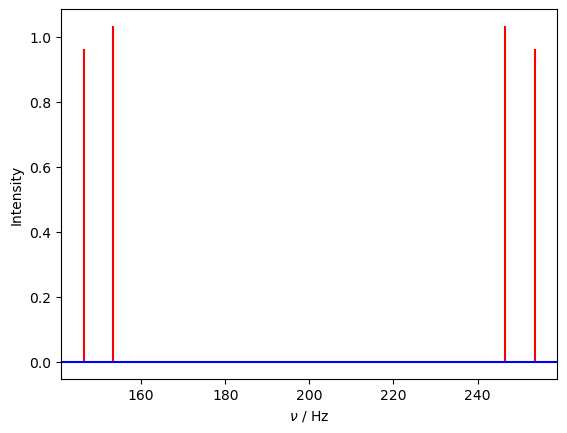

In [24]:
case = {nuA:150,nuB:250,JAB:7}
ffMC = ffM.evalf(subs=case)
print("toto")
TEMC = TEM.evalf(subs=case)
IntC = Intensities.evalf(subs=case)
ple(ffMC)
ple(TEMC)
ple(IntC)

affC, aIntC = NonZeroFreqAndInt2Array(TEMC,IntC)
print(affC)
print(aIntC)

plt.vlines(affC, 0, aIntC, color='r')
plt.axhline(0,color='b')
plt.xlabel("$\\nu$ / Hz")
plt.ylabel("Intensity")

#### **3.2.b.** nuA = 195 Hz, nuB = 205 Hz, JAB = 7 Hz

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

[202.603277807867 190.396722192133 197.396722192133 209.603277807867]
[1.25437727353589 0.653098503777701 1.25437727353589 0.653098503777701]


Text(0, 0.5, 'Intensity')

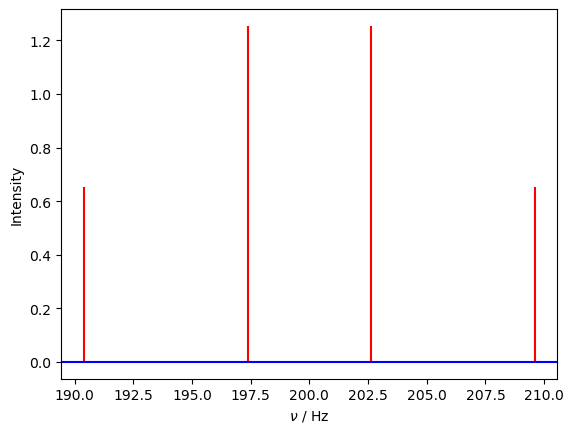

In [25]:
case = {nuA:195,nuB:205,JAB:7}
ffMC = ffM.evalf(subs=case)
TEMC = TEM.evalf(subs=case)
IntC = Intensities.evalf(subs=case)
ple(ffMC)
ple(TEMC)
ple(IntC)

affC, aIntC = NonZeroFreqAndInt2Array(TEMC,IntC)
print(affC)
print(aIntC)

plt.vlines(affC, 0, aIntC, color='r')
plt.axhline(0,color='b')
plt.xlabel("$\\nu$ / Hz")
plt.ylabel("Intensity")

### **3.3.** Animation plots

#### **3.3.a.** Variation of intensities as a function of the resonance frequencies

In [26]:
%matplotlib notebook
import matplotlib.animation as animation
fig, ax = plt.subplots()

# Create all the cases = list of dictionaries
minF = 400
maxF = 600
avF = (minF + maxF)/2
step = 1
FcasesA = np.arange(minF,avF, step)
FcasesB = np.arange(maxF,avF, -step)
nFrames = len(FcasesA)
print(f"Number of frames : {nFrames}")
#print(FcasesA)
#print(FcasesB)

cases = []
for i in range(nFrames):
    cases.append({nuA:FcasesA[i],nuB:FcasesB[i],JAB:7})
#print(cases)

TEMC = TEM.evalf(subs=cases[0])
IntC = Intensities.evalf(subs=cases[0])
affC, aIntC = NonZeroFreqAndInt2Array(TEMC,IntC)

ax.vlines(affC, 0, aIntC, color='r')
ax.axhline(0,color='b',linewidth=0.5)
ax.set_xlabel("$\\nu$ / Hz")
ax.set_ylabel("Intensity")

def animate(i,cases,TEM,Intensities):
    TEMC = TEM.evalf(subs=cases[i])
    IntC = Intensities.evalf(subs=cases[i])
    affC, aIntC = NonZeroFreqAndInt2Array(TEMC,IntC)
    ax.clear()
    ax.vlines(affC, 0, aIntC, color='r')
    ax.axhline(0,color='b',linewidth=0.5)
    ax.set_xlabel("$\\nu$ / Hz")
    ax.set_ylabel("Intensity")
    return

from IPython.display import HTML
ani = animation.FuncAnimation(fig, animate, fargs=(cases,TEM,Intensities), interval=100, frames=nFrames)
HTML(ani.to_jshtml())

<IPython.core.display.Javascript object>

Number of frames : 100


In [27]:
#Calculating intensities and frequencies for all frames before the call to animation.FuncAnimation does not seem more efficient
# %matplotlib notebook
# import matplotlib.animation as animation
# fig, ax = plt.subplots()

# # Create all the cases = list of dictionaries
# minF = 400
# maxF = 600
# avF = (minF + maxF)/2
# step = 1
# FcasesA = np.arange(minF,avF, step)
# FcasesB = np.arange(maxF,avF, -step)
# nFrames = len(FcasesA)
# print(f"Number of frames : {nFrames}")
# #print(FcasesA)
# #print(FcasesB)

# cases = []
# for i in range(nFrames):
#     cases.append({nuA:FcasesA[i],nuB:FcasesB[i],JAB:7})
# #print(cases)

# affCt = []
# aIntCt = []
# for i in range(nFrames):
#     TEMC = TEM.evalf(subs=cases[i])
#     IntC = Intensities.evalf(subs=cases[i])
#     affC, aIntC = NonZeroFreqAndInt2Array(TEMC,IntC)
#     affCt.append(affC)
#     aIntCt.append(aIntC)

# def animate(i,affCt,aIntCt):
#     ax.clear()
#     ax.vlines(affCt[i], 0, aIntCt[i], color='r')
#     ax.axhline(0,color='b',linewidth=0.5)
#     ax.set_xlabel("$\\nu$ / Hz")
#     ax.set_ylabel("Intensity")
#     return

# from IPython.display import HTML
# ani = animation.FuncAnimation(fig, animate, fargs=(affCt,aIntCt), interval=100, frames=nFrames)
# HTML(ani.to_jshtml())

#### **3.3.b.** Variation of intensities as a function of the absolute resonance frequency of a standard reference compound

##### Simulation of an AB spectrum at 60 MHz

The goal of this first part is to simulate the AB part of the 3,6-dimethyl-2-nitroaniline 1H-NMR spectrum
<p style="text-align: center"><img width="500px" src="./MiscImages/1HNMR-3,6-dimethyl-2-nitroaniline.jpg" style="margin-left:auto; margin-right:auto" id="img_jpc"/></img></p>
<p style="text-align: center">(<i>spectrum taken from:</i> H. Günther, NMR Spectroscopy: Basic Principles, Concepts, and Applications in Chemistry, Wiley, 2013)</span>

delta = 6.3 ppm. The absolute frequency of the sample is 60.000378 MHz on a 60 MHz spectrometer
And it corresponds to 378.00 Hz from the TMS resonance
delta = 6.8 ppm. The absolute frequency of the sample is 60.000408 MHz on a 60 MHz spectrometer
And it corresponds to 408.00 Hz from the TMS resonance


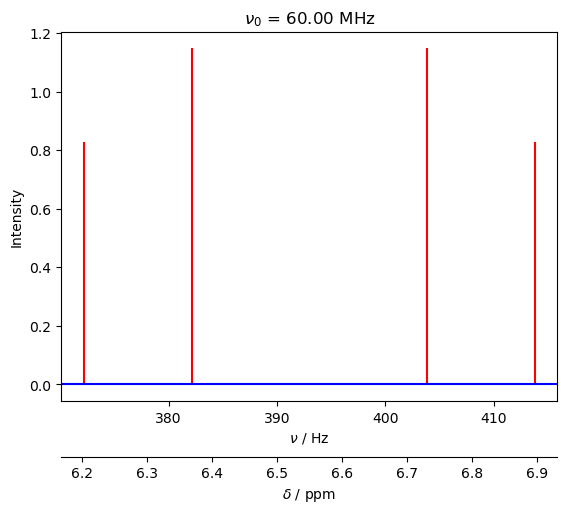

In [28]:
%matplotlib inline
_nu0 = 60 #MHz
_deltaA = 6.3 #ppm
_deltaB = 6.8 #ppm
_nuA_rel = nuX_rel(_deltaA,_nu0)
_nuB_rel = nuX_rel(_deltaB,_nu0)

print(f"delta = {_deltaA} ppm. The absolute frequency of the sample is {nuX(_deltaA,_nu0)} MHz on a {_nu0} MHz spectrometer")
print(f"And it corresponds to {_nuA_rel:.2f} Hz from the TMS resonance")

print(f"delta = {_deltaB} ppm. The absolute frequency of the sample is {nuX(_deltaB,_nu0)} MHz on a {_nu0} MHz spectrometer")
print(f"And it corresponds to {_nuB_rel:.2f} Hz from the TMS resonance")

_JAB = 10 #Hz
case = {nuA:_nuA_rel,nuB:_nuB_rel,JAB:_JAB}
ffMC = ffM.evalf(subs=case)
TEMC = TEM.evalf(subs=case)
IntC = Intensities.evalf(subs=case)
affC, aIntC = NonZeroFreqAndInt2Array(TEMC,IntC)
#print(affC)
#print(aIntC)

def NuX_rel(_deltaX):
    return 1e6*(nuX(_deltaX, _nu0)-nuX(0, _nu0))

def DeltaX_rel(_nuX_rel):
    return _nuX_rel/_nu0

fig, ax = plt.subplots()
ax.vlines(affC, 0, aIntC, color='r')
ax.axhline(0,color='b')
ax.set_xlabel("$\\nu$ / Hz")
ax.set_ylabel("Intensity")
ax.set_title(f"$\\nu_0$ = {_nu0:.2f} MHz")
secaxx = ax.secondary_xaxis(-0.15, functions=(DeltaX_rel, NuX_rel))
secaxx.set_xlabel('$\delta$ / ppm')
plt.show()

##### Animated plot of the same actual AB spectrum, from 60 MHz to 600 MHz 

In [29]:
%matplotlib notebook
import matplotlib.animation as animation
fig, ax = plt.subplots()

_nu0 = 60 #MHz
_deltaA = 6.3 #ppm
_deltaB = 6.8 #ppm
_nuA_rel = nuX_rel(_deltaA,_nu0) #in Hz
_nuB_rel = nuX_rel(_deltaB,_nu0) #in Hz
_JAB = 10 #Hz

print(f"delta = {_deltaA} ppm. The absolute frequency of the sample is {nuX(_deltaA,_nu0)} MHz on a {_nu0} MHz spectrometer")
print(f"And it corresponds to {_nuA_rel:.2f} Hz from the TMS resonance")

print(f"delta = {_deltaB} ppm. The absolute frequency of the sample is {nuX(_deltaB,_nu0)} MHz on a {_nu0} MHz spectrometer")
print(f"And it corresponds to {_nuB_rel:.2f} Hz from the TMS resonance")

# Create all the cases = list of dictionaries
minF = 60
maxF = 600
step = 1
_nu0tab = np.array([60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300, 350, 400, 450, 500, 550, 600])
nFrames = len(_nu0tab)
print(f"Number of frames : {nFrames}")

cases = []
for _nu0 in _nu0tab:
    _nuA_rel = nuX_rel(_deltaA,_nu0)
    _nuB_rel = nuX_rel(_deltaB,_nu0)
    cases.append({nuA:_nuA_rel,nuB:_nuB_rel,JAB:_JAB})
#print(cases)

TEMC = TEM.evalf(subs=cases[0])
IntC = Intensities.evalf(subs=cases[0])
affC, aIntC = NonZeroFreqAndInt2Array(TEMC,IntC)
#print(affC)
#print(aIntC)



fig, ax = plt.subplots()

def animate(i,cases,_nu0tab,TEM,Intensities):
    def NuX_rel(_deltaX):
        return 1e6*(nuX(_deltaX, _nu0tab[i])-nuX(0, _nu0tab[i]))
    def DeltaX_rel(_nuX_rel):
        return _nuX_rel/_nu0tab[i]
    TEMC = TEM.evalf(subs=cases[i])
    IntC = Intensities.evalf(subs=cases[i])
    affC, aIntC = NonZeroFreqAndInt2Array(TEMC,IntC)
    ax.clear()
    ax.vlines(affC, 0, aIntC, color='r')
    ax.axhline(0,color='b')
    ax.set_xlabel("$\\nu$ / Hz")
    ax.set_ylabel("Intensity")
    ax.set_title(f"$\\nu_0$ = {_nu0tab[i]:.2f} MHz",y=1.0, pad=-14)
    secaxx = ax.secondary_xaxis(1, functions=(DeltaX_rel, NuX_rel))
    secaxx.set_xlabel('$\delta$ / ppm')
    #secaxx.set_xlim([_deltaA-1,_deltaB+1]) #ça ne marche pas
    return

from IPython.display import HTML
ani = animation.FuncAnimation(fig, animate, fargs=(cases,_nu0tab,TEM,Intensities), interval=500, frames=nFrames)
HTML(ani.to_jshtml())

<IPython.core.display.Javascript object>

delta = 6.3 ppm. The absolute frequency of the sample is 60.000378 MHz on a 60 MHz spectrometer
And it corresponds to 378.00 Hz from the TMS resonance
delta = 6.8 ppm. The absolute frequency of the sample is 60.000408 MHz on a 60 MHz spectrometer
And it corresponds to 408.00 Hz from the TMS resonance
Number of frames : 17


<IPython.core.display.Javascript object>

In [75]:
vID.end(cwd0)

**End at:** Tuesday 29 November 2022, 22:51:12  
**Duration:** 01:54:22 757ms

<p style="text-align: center"><img width="800px" src="./config/svg/logoEnd.svg" style="margin-left:auto; margin-right:auto"/></p>